In [1]:
# Patient details file yaml/json
import yaml
from datetime import datetime, timedelta


import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('png', 'pdf')

import seaborn as sns
plt.rcParams['lines.linewidth'] = 0.75

import numpy as np
import pandas as pd
def df_repr_latex(self):
    return '\n'.join([
        r'\vspace{5mm}',
        r'{\scriptsize{\centering{%s}}}' % self.to_latex(),
        r'\vspace{5mm}'
    ])
pd.DataFrame._repr_latex_ = df_repr_latex
from pandas.io.formats.style import Styler
Styler._repr_latex_ = lambda s: s.data._repr_latex_()

class HTMLLatex:
    def __init__(self, html, latex):
        self.html = html
        self.latex = latex
    def _repr_html_(self): return self.html
    def _repr_latex_(self): return self.latex
NewPage = HTMLLatex('<hr>', r'\clearpage\newpage')

from IPython.display import display, HTML, Latex

from dcmfetch import fetch_series
from mriqa.reports import (
    ghosting_report, slice_profile_report, piqt_distortion_report,
    uniformity_report, snr_report, snr_report_multi, svs_report, fid_report,
    phase_background_report, fbirn_full_report, mtf_report
)
from mriqa.phantoms import SIEMENSLONGBOTTLE, PIQTSP
from mriqa.tools import show_montage, watermark
from mriqa.dcmio import qa_date, scanner_operator, larmor_frequency
from mriqa.xmlqa.coilqa import (
    find_qa_results_file,
    coil_snr, coil_snr_history, coil_name, coil_names,
    plot_coil_images, 
    MINCOILSERNO
)

from dcmextras.siemenscsa import csa, phoenix

# Percent above specification
MARGIN = 5 
margin_colour = lambda x: 'color: %s' % ('green' if x>= MARGIN else 'orange' if x>0 else 'red')
ok_colour     = lambda x: 'color: %s' % ('green' if x else 'red')

# -- Watermark ---
wm = watermark()
display(
    pd.DataFrame(
        {'Watermark': list(wm.values())},
        index=wm.keys())
)

Watermark
CalculationTime  2020-12-17T16:37:01+00:00
User                    birchhub/elberthol
PythonVersion                CPython 3.7.9
Platform           Linux 4.15.0-76-generic
mriqa                                0.2.7
dcmextras                            0.2.6
pydicom                              2.1.0
scipy                                1.5.2
numpy                               1.19.2
skimage                             0.17.2
matplotlib                           3.3.2

### Details of series to Analyse.
The Patient ID, the Study ID and the Series Numbers of the QA scans.

In [2]:
with open('study.yml') as fp:
    study_info = yaml.safe_load(fp)

patid, studyid = study_info['PatID'], study_info.get('StudyID', '1')
tests = study_info['Tests']
for k, test in tests.items():
    if 'PatID' not in test:
        test['PatID'] = patid
    if 'StudyID' not in test:
        test['StudyID'] = studyid

series = tests['SliceProfile_PIQT']['Series']['3mm']

d = fetch_series(patid, studyid, sernos=series)[0]
scanner, date_of_scan, operator = d.StationName, qa_date(d), scanner_operator(d, 'BIRCH')
display(
    pd.DataFrame(
        {'Details':[scanner, date_of_scan, patid, studyid]}, 
        index=['Scanner', 'Date', 'Patient', 'Study']
    )
)

Details
Scanner              MRC25843
Date                 20190919
Patient  AQA20190919BRIAVANTO
Study                       1

# Summary
Tests Performed:

- Slice shape and Profile
- Distortion and Field of View
- Resolution
- Ghosting
- Head Coil SNR
- Head Coil Image Uniformity
- Long Term Stability

All of the above are acceptable.

----

### Recommended Actions

No actions necessary.

In [3]:
aqadate = (datetime.strptime(date_of_scan, '%Y%m%d') + timedelta(days=365)).strftime('%B %Y')

text = f'''
This machine is next due for Annual QA tests in {aqadate}.
'''

HTMLLatex(text, text)

----

In [4]:
text = f'''
BIRCH
Medical Physics & Bioengineering, UHBW
{datetime.strptime(date_of_scan, '%Y%m%d').strftime('%B %Y')}
'''

HTMLLatex(
    f'<pre>{text}</pre>',
    '\n'.join([
        r'\begin{verbatim}',
        text,
        r'\end{verbatim}'
    ])
)

In [5]:
NewPage

## Slice Profile

These are the profiles of 3mm and 5mm slices in a conventional spin echo with a T<sub>E</sub> of 30ms using the PIQT slice profile block.

### 3 mm Slice

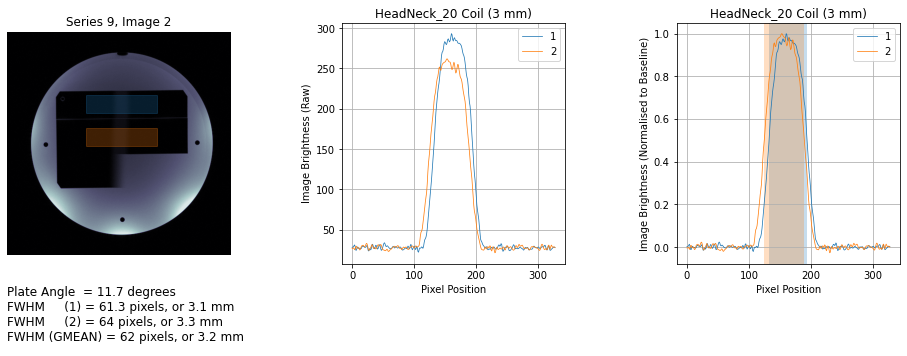

In [6]:
# TO2: Slice 3mm
info = tests['SliceProfile_PIQT']
series, slice_idx = info['Series']['3mm'], info['Slice']['3mm']

# Distortion Corrected, Phase RL, Non-Uniformity Corrected 512*512
dobjs = fetch_series(patid, studyid, sernos=series)
results = slice_profile_report(dobjs[slice_idx], phantom=PIQTSP, flipped_ud=False, flipped_rl=False)

### 5 mm Slice

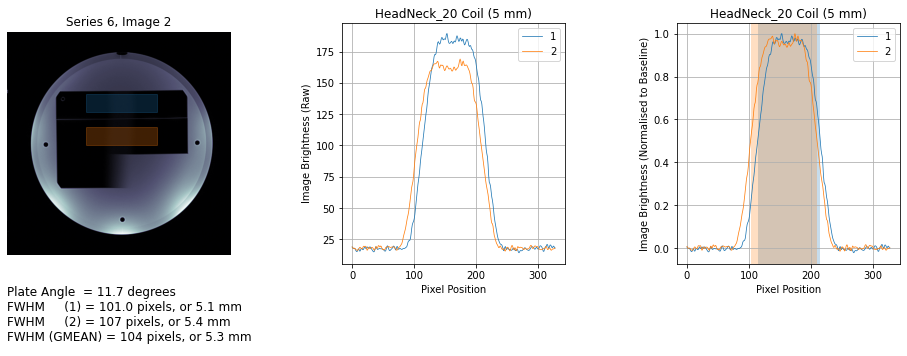

In [7]:
# TO2: Slice 5mm
# Distortion Corrected, Phase RL, Non-Uniformity Corrected 512*512
info = tests['SliceProfile_PIQT']
series, slice_isx = info['Series']['5mm'], info['Slice']['5mm']
dobjs = fetch_series(patid, studyid, sernos=series)
result = slice_profile_report(dobjs[slice_idx], phantom=PIQTSP, flipped_ud=False, flipped_rl=False)
results = results.append(result)

In [8]:
pd.set_option('precision', 1)
results[['FWHMGMeanPixels', 'FWHMGMeanMM']].rename(columns={
    'FWHMGMeanPixels': 'Projected FWHM (pixels)',
    'FWHMGMeanMM': 'True FWHM (mm)'
})

Projected FWHM (pixels)  True FWHM (mm)
SliceThickness                                         
3.0                                62.9             3.2
5.0                               104.0             5.3

These are both rather rounded profiles as seen on other Siemens scanners with this protocol. The profile widths, though, are well within the AAPM tolerance of 0.5mm.

In [9]:
NewPage

## Image Scaling and Geometric Distortion

The PIQT phantom has a a grid of objects for scale and distortion measurements in plane. The scale reflects the Gradient Sensitivity calibration performed by the manufacturer as part of the system installation. These results are *after* applying Siemens 2D distortion correction.

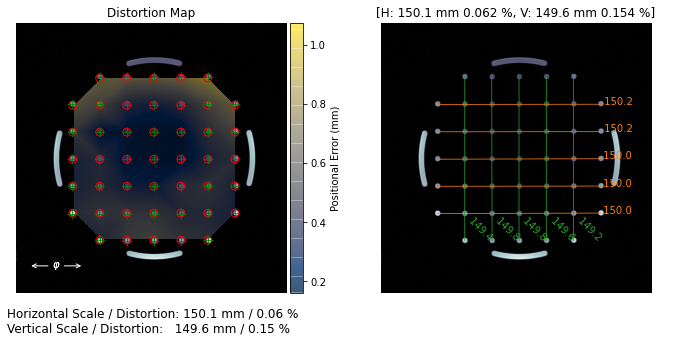

In [10]:
# PIQT: Distortion
info = tests['Distortion_PIQT']
patid, studyid = info['PatID'], info['StudyID']
series, slices = info['Series'], info['Slice']

# SE: Axial, Phase RL, 512 matrix
dobj = fetch_series(patid, studyid, sernos=series['AxialRL_Corrected'])[slices['AxialRL_Corrected']]
results = piqt_distortion_report(dobj)

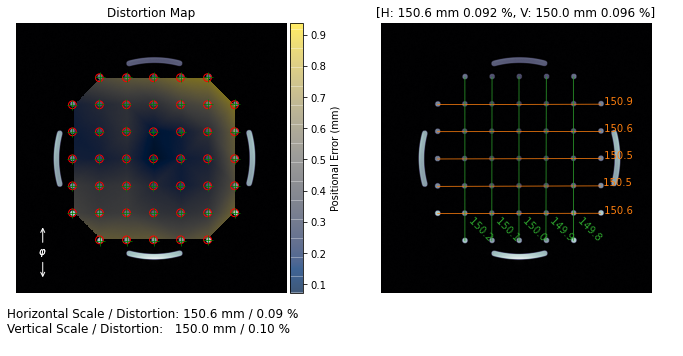

In [11]:
# PIQT: Distortion
# SE: Axial, Phase AP, 512 matrix
dobj = fetch_series(patid, studyid, sernos=series['AxialAP_Corrected'])[slices['AxialAP_Corrected']]
results = results.append(piqt_distortion_report(dobj))

In [12]:
pd.set_option('precision', 3)
results[[
    'Orientation', 'PhaseDirection', 'Sensitivity',
    'HorizontalScale', 'HorizontalDistortion',
    'VerticalScale', 'VerticalDistortion'
]].rename(columns={
    'PhaseDirection': 'Phase Direction',
    'HorizontalScale': 'Horizontal Scale (mm)', 'HorizontalDistortion':'Horizontal Distortion',
    'VerticalScale': 'Vertical Scale (mm)', 'VerticalDistortion': 'Vertical Distortion'  
})

Orientation Phase Direction  Sensitivity  Horizontal Scale (mm)  \
Series                                                                   
8            Axial              RL        0.239                150.070   
10           Axial              AP        0.239                150.627   

        Horizontal Distortion  Vertical Scale (mm)  Vertical Distortion  
Series                                                                   
8                       0.062              149.556                0.154  
10                      0.092              150.000                0.096

The scale in both the RL and AP directions are well within 1% at the bandwidth used (130Hz/pixel).

In [13]:
NewPage

## Resolution

Image resolution is estimated by analysis of the MTF block in the PIQT phantom. These results are from an axial slice acquired using a conventional spin ech owith 0.5 x 0.5 mm nominal resolution.

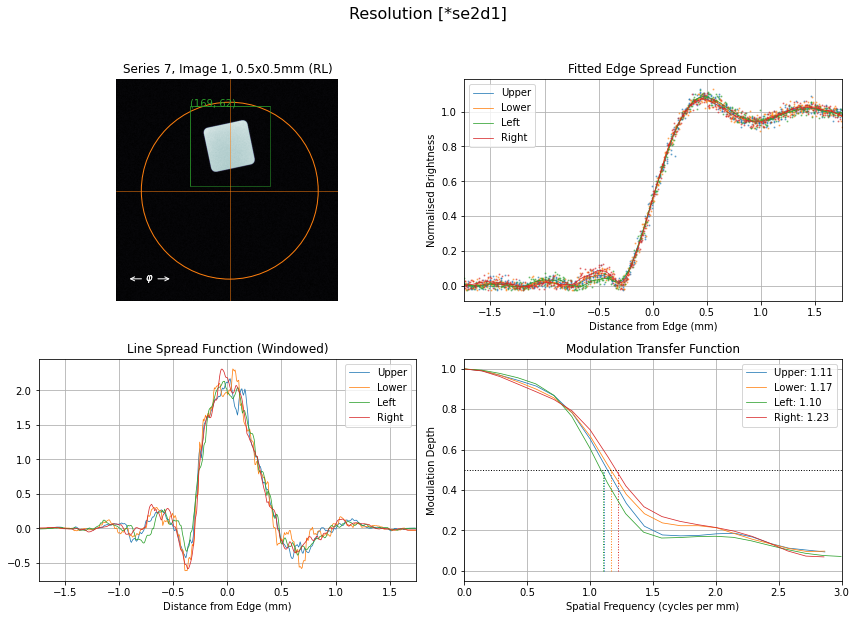

MTF_50
Upper   1.112
Lower   1.170
Left    1.101
Right   1.226

In [14]:
# PIQT: Resoution/MTF
info = tests['Resolution_PIQT']
patid, studyid = info['PatID'], info['StudyID']
series, slices = info['Series'], info['Slice']

# SE: Axial, Phase RL, 512 matrix
dobjs = sorted(fetch_series(patid, studyid, sernos=[series['SE512']]), key=lambda d: int(d.InstanceNumber))
dobj_mtf, dobj_centre = dobjs[slices['MTF']], dobjs[slices['Centre']]

results = mtf_report(dobj_mtf, dobj_centre)
plt.show()
results

The MTF_50 is consistent with an image resolution of 0.5 x 0.5 mm.

In [15]:
NewPage

## Ghosting

Image ghosting is assessed following the approach of [AAPM report 100](https://www.aapm.org/pubs/reports/RPT_100.pdf) for the transverse orientation and four example sequences.

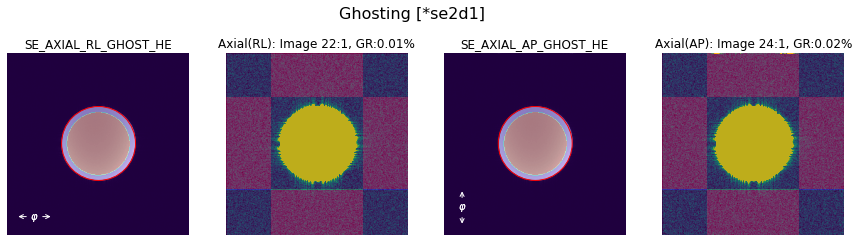

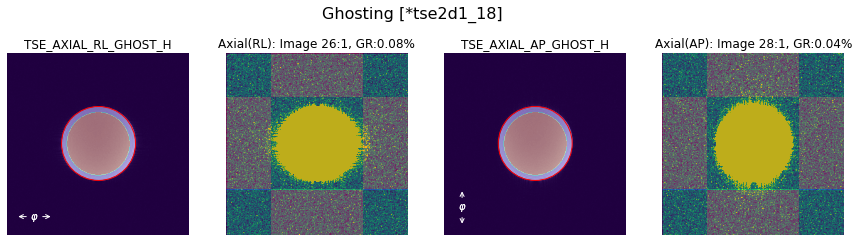

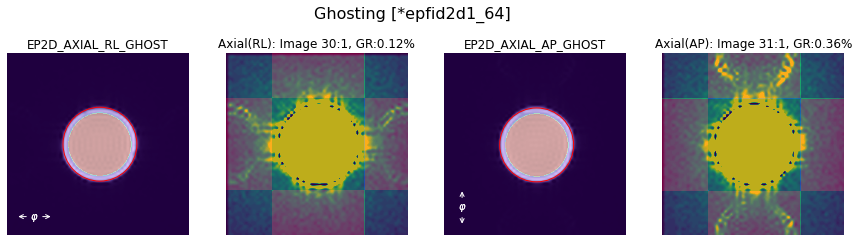

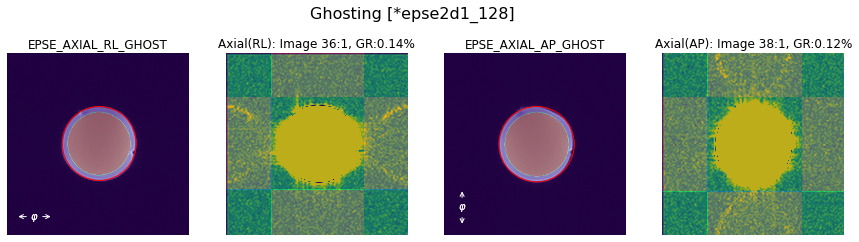

Sequence Orientation Phase Direction  Ghost Ratio (%)
Series                                                           
22            *se2d1       Axial              RL            0.011
24            *se2d1       Axial              AP            0.017
26        *tse2d1_18       Axial              RL            0.079
28        *tse2d1_18       Axial              AP            0.044
30      *epfid2d1_64       Axial              RL            0.125
31      *epfid2d1_64       Axial              AP            0.365
36      *epse2d1_128       Axial              RL            0.139
38      *epse2d1_128       Axial              AP            0.122

In [16]:
# GE10CM: Ghosting
info = tests['Ghosting_GE10']
patid, stuid = info['PatID'], info['StudyID']
series = info['Series']

# SE Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in series['SE']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = ghosting_report(dobjs, axes=list(axs.flat))

# TSE18 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in series['TSE']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))

# EPI64 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in series['EP2D']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))
plt.show()

# EPISE128 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in series['EPSE']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))
plt.show()

with pd.option_context('display.precision', 3):
    display(
        results[['Sequence', 'Orientation', 'PhaseDirection', 'GhostRatio']].rename(columns={
            'PhaseDirection': 'Phase Direction', 'GhostRatio': 'Ghost Ratio (%)'
        })
    )

The level of ghosting is under 1% for all sequences measured here including the EPIs. The worst ghosting is seen on the GRE EPI and looks to be predominantly first order. 

In [17]:
NewPage

## Receiver Coil Uniformity

We have tested the uniformity of the standard head/neck coil using a spherical phantom filled with a silicone oil. Results are presented both before and after Siemens `prescan-normalize` intensity correction.

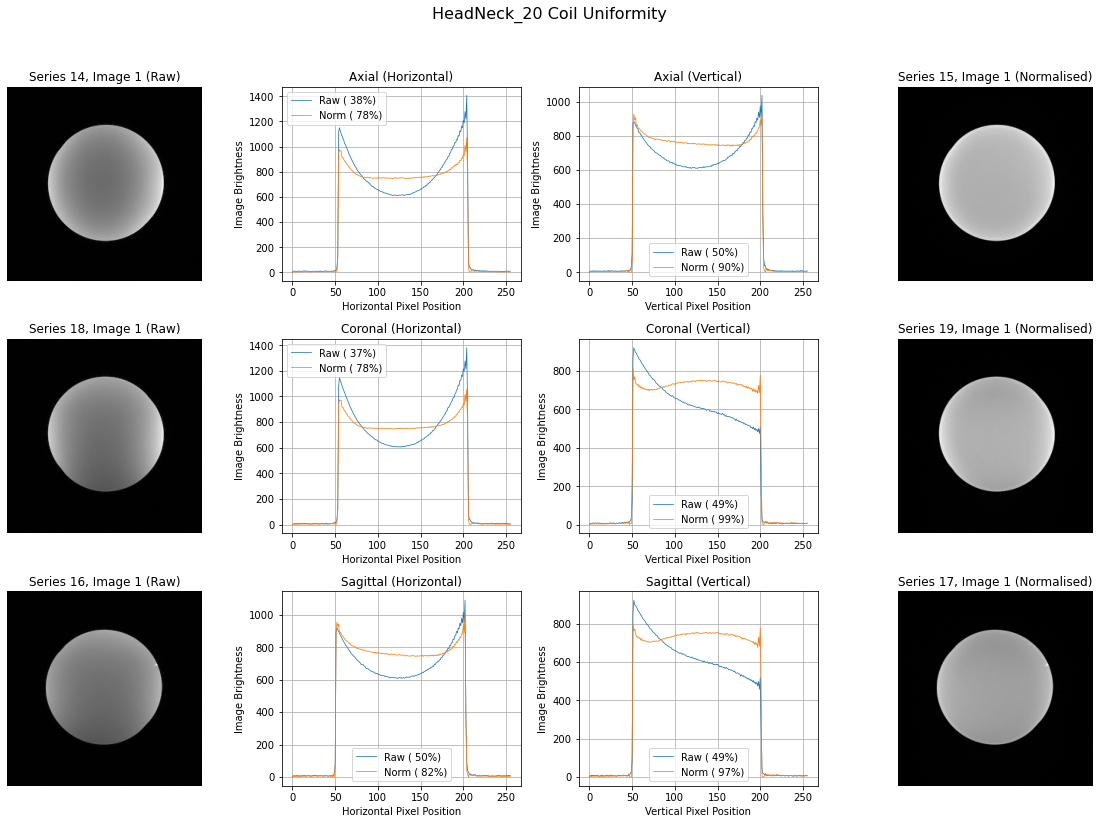

Raw Images


Series No.                                   Protocol  \
Orientation                                                          
Axial                14     SE_AXIAL_RL_UNIF_HEAD_OILSPHERE_TR1000   
Coronal              18   SE_CORONAL_RL_UNIF_HEAD_OILSPHERE_TR1000   
Sagittal             16  SE_SAGITTAL_AP_UNIF_HEAD_OILSPHERE_TR1000   

                    Axis   X Uniformity (%)  Y Uniformity (%)  
Orientation                                                    
Axial           Axial/RL              38.16             50.33  
Coronal       Coronal/RL              36.84             49.01  
Sagittal     Sagittal/AP              49.67             49.01

Intensity Normalised Images


Series No.                                   Protocol  \
Orientation                                                          
Axial                15     SE_AXIAL_RL_UNIF_HEAD_OILSPHERE_TR1000   
Coronal              19   SE_CORONAL_RL_UNIF_HEAD_OILSPHERE_TR1000   
Sagittal             17  SE_SAGITTAL_AP_UNIF_HEAD_OILSPHERE_TR1000   

                    Axis   X Uniformity (%)  Y Uniformity (%)  
Orientation                                                    
Axial           Axial/RL              77.63             89.54  
Coronal       Coronal/RL              77.63             98.68  
Sagittal     Sagittal/AP              82.35             96.69

In [18]:
# OILSPHERE: Uniformity
# SE Axial,Coronal,Sagittal; w w/o Intensity Normalization
info = tests['Uniformity_Oil']
patid, stuid = info['PatID'], info['StudyID']
series = info['Series']

raw_tra = fetch_series(patid, stuid, sernos=series['Axial'][0])
psn_tra = fetch_series(patid, stuid, sernos=series['Axial'][1])
raw_sag = fetch_series(patid, stuid, sernos=series['Sagittal'][0])
psn_sag = fetch_series(patid, stuid, sernos=series['Sagittal'][1])
raw_cor = fetch_series(patid, stuid, sernos=series['Coronal'][0])
psn_cor = fetch_series(patid, stuid, sernos=series['Coronal'][1])

if len(raw_tra) > 1:
    results = uniformity_report(
        raw_dobjs=[raw_tra[0], raw_sag[0], raw_cor[0]],
        psn_dobjs=[psn_tra[0], psn_sag[0], psn_cor[0]],
        raw_dobjsb=[raw_tra[1], raw_sag[1], raw_cor[1]],
        psn_dobjsb=[psn_tra[1], psn_sag[1], psn_cor[1]]
    )
else:
    results = uniformity_report(
        raw_dobjs=[raw_tra[0], raw_sag[0], raw_cor[0]],
        psn_dobjs=[psn_tra[0], psn_sag[0], psn_cor[0]],
    )

plt.show()

with pd.option_context('display.precision', 2):
    print('Raw Images')
    display(
        results[['SeriesRaw',  'ProtocolRaw',  'OrientRaw', 'XUniformityRaw', 'YUniformityRaw']].rename(columns={
            'SeriesRaw': 'Series No.', 'ProtocolRaw': 'Protocol', 'OrientRaw': 'Axis',
            'XUniformityRaw': ' X Uniformity (%)', 'YUniformityRaw': 'Y Uniformity (%)'
        })
    )
    print('Intensity Normalised Images')
    display(
        results[['SeriesNorm', 'ProtocolNorm', 'OrientNorm', 'XUniformityNorm', 'YUniformityNorm']].rename(columns={
            'SeriesNorm': 'Series No.', 'ProtocolNorm': 'Protocol', 'OrientNorm': 'Axis',
            'XUniformityNorm': ' X Uniformity (%)', 'YUniformityNorm': 'Y Uniformity (%)'
        })
    )

As expected for a multi-element coil the uncorrected images are significantly non-uniform. However, the Siemens `prescan-normalize` intensity correction is adequate in compensating for this.

In [19]:
NewPage

## Signal to Noise

The Siemens QA involves a comprehensive element by element assessment of the SNR of all the coils. For reference purposes the following is an independent estimate for the standard head/neck coil using the Siemens long bottle phantom. The SNR is estimated over centred discs with diameters 50% and 75% of the phantom. The signal is taken from a region within the phantom in the mean of two images and the noise is estimated from a background region in their difference image.

### 20 Channel Head/Neck Coil

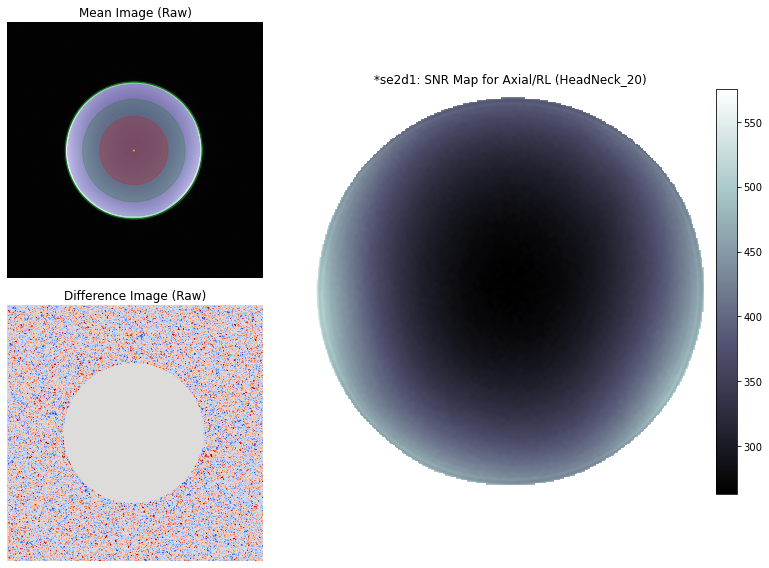

SNR: Raw Images


HeadNeck_20
RegionSize             
0.50              287.0
0.75              315.0

In [20]:
# LONGBOTTLE: Signal to Noise
info = tests['QuarterlySNR']
patid, stuid = info['PatID'], info['StudyID']
series = info['Series']

raw_tra = fetch_series(patid, stuid, sernos=series['Signal_Combined'])
if len(raw_tra) > 1:
    results = snr_report(raw_dobjs=[raw_tra[0]], raw_dobjsb=[raw_tra[1]])
else:
    results = snr_report(raw_dobjs=[raw_tra[0]])
plt.show()

print('SNR: Raw Images')
with pd.option_context('display.precision', 2):
    display(np.round(results))

These results are similar to those we have obtained on other 1.5T Siemens scanners under these conditions.

In [21]:
NewPage

### Single-element Images
This is the SNR calculated from individual element images combined as a sum of squares. This is the methodology used in the quarterly QA.

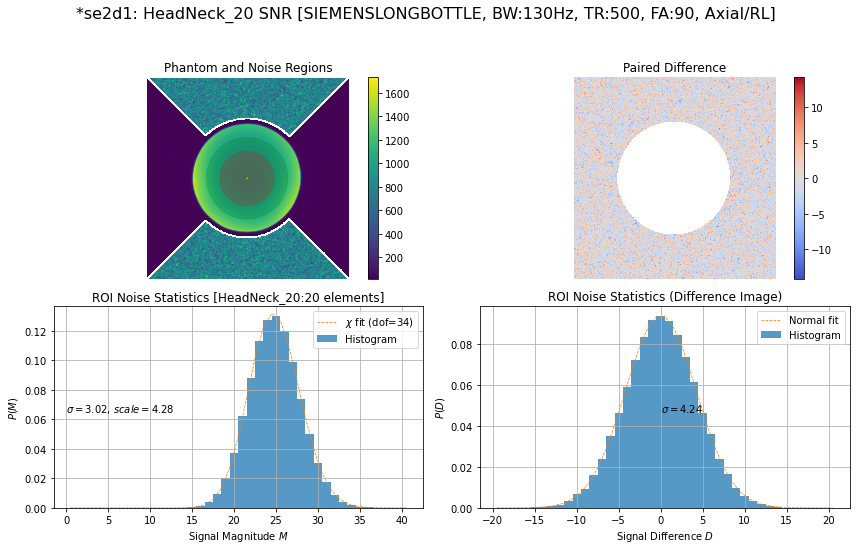

HeadNeck_20
0.50       287.99
0.75       316.25

In [22]:
# SNR (uncombined channels)
from mriqa.dcmio import coil_elements
dobjs = sorted(
    fetch_series(patid, stuid, series['Signal']),
    key=lambda x: (int(x.SeriesNumber), int(x.AcquisitionNumber), coil_elements(x)[0])
)
nchannels = len(set(coil_elements(d)[0] for d in dobjs))
dobjsa, dobjsb = dobjs[:nchannels], dobjs[nchannels:]

with pd.option_context('display.precision', 2):
    display(snr_report_multi(dobjsa, dobjsb, phantom=SIEMENSLONGBOTTLE))

In [23]:
NewPage

## Long Term Stability
We assessed the long term stability of an EPI acquisition over a period of 20 minutes. This was performed on a spherical silicone oil phantom using the bold (mosaic) EPI sequence.

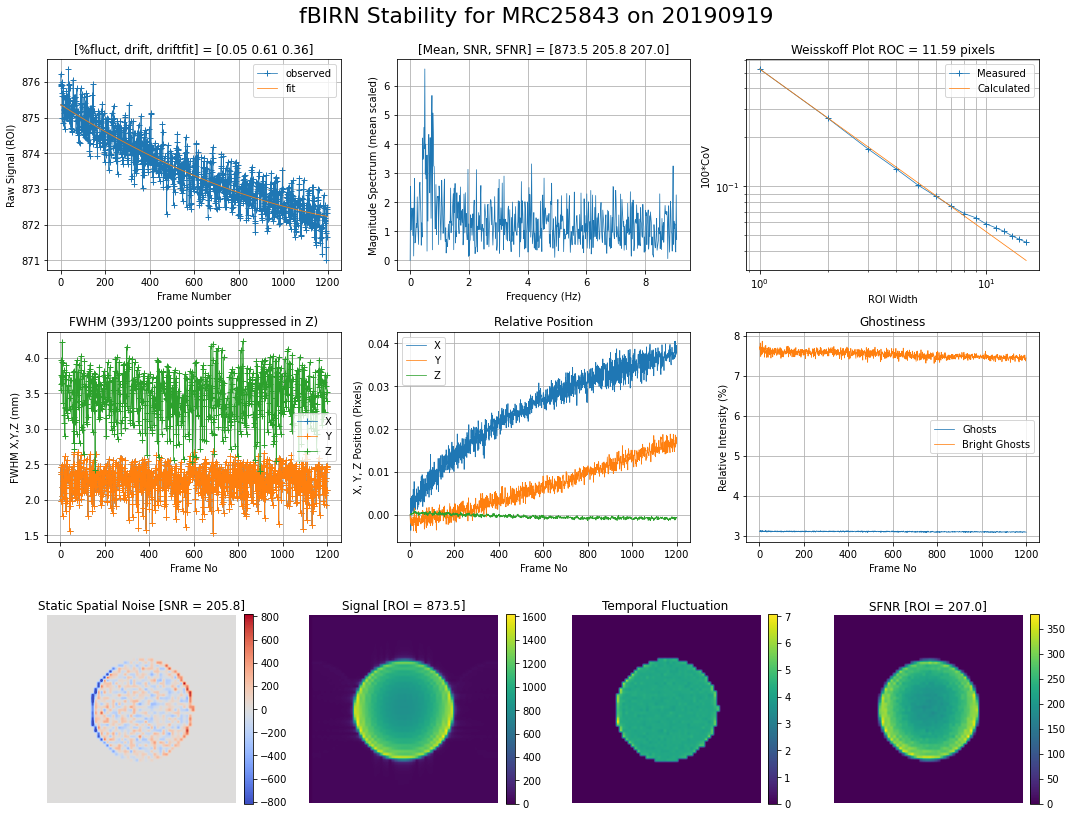

Fluctuations  FittedDrift  Ghosts  BrightGhosts  \
MRC25843_20190919         0.045        0.359   3.097         7.531   

                   SignalMean      SNR     SFNR  
MRC25843_20190919     873.518  205.769  207.005

In [24]:
# FBIRN Spherical Phantom: Long Term stability
info = tests['Stability']
patid, studyid = info['PatID'], info['StudyID']
series = info['Series']

dobjs = fetch_series(patid, studyid, sernos=series['Long_20min'])
results = fbirn_full_report(dobjs)
plt.show()
results

The relatively high Nyquist ghost level is typical of Siemens scanners under these test conditions.

In [25]:
NewPage

### Frequency Reference and Transmitter Voltage
These are the reference values reported in the DICOM header of the Localizer scan.

In [26]:
# Siemens Long Bottle: localizer
info = tests['TuneupParams']
patid, studyid = info['PatID'], info['StudyID']
series = info['Series']
dobj = fetch_series(patid, studyid, sernos=series)[0]

csa_tags = csa(dobj)
phoenix_tags = phoenix(dobj)

pd.DataFrame({
    'ImagingFrequency': [float(dobj.ImagingFrequency)],
    'TransmitterCalibration': [float(csa_tags['TransmitterCalibration'])],
    'TalesReferencePower': [float(csa_tags['TalesReferencePower'])],
    'GradientSensitivityX': [
        float(phoenix_tags['sGRADSPEC.asGPAData[0].flSensitivityX']) * 1e6,
    ],
    'GradientSensitivityY': [
        float(phoenix_tags['sGRADSPEC.asGPAData[0].flSensitivityY']) * 1e6,
    ],
    'GradientSensitivityZ': [
        float(phoenix_tags['sGRADSPEC.asGPAData[0].flSensitivityZ']) * 1e6
    ]
}, index=['Value']).T

Value
ImagingFrequency         63.571
TransmitterCalibration  227.224
TalesReferencePower     531.405
GradientSensitivityX     78.501
GradientSensitivityY     78.342
GradientSensitivityZ     91.134